# Image Classification Project

Using supervised algorithm with Keras and TensorFlow. This is a ongoing project that uses deep learning to identify SEM (scanning electron microscope) images of spiders. The images are divided in 6 categories (chelicerae, eyes, legs, palp, spinnerets, and trichobothia), which are used to describe important features in spider morphology. 
As a ongoing project, the images used are not going to be public in this repository.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

https://www.tensorflow.org/tutorials/images/classification#download_and_explore_the_dataset

https://keras.io/api/preprocessing/image/

In [2]:
batch_size = 32
img_height = 180
img_width = 180

## Load Dataset

In [3]:
train_spider = tf.keras.preprocessing.image_dataset_from_directory(
  'images',
  labels="inferred",
  color_mode="rgb",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5841 files belonging to 6 classes.
Using 4673 files for training.


In [4]:
val_spider = tf.keras.preprocessing.image_dataset_from_directory(
  'images',
  labels="inferred",
  color_mode="rgb",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5841 files belonging to 6 classes.
Using 1168 files for validation.


In [5]:
class_names = train_spider.class_names
print(class_names)

['chelicerae', 'eyes', 'legs', 'palp', 'spinnerets', 'trichobothia']


## Visualize the data

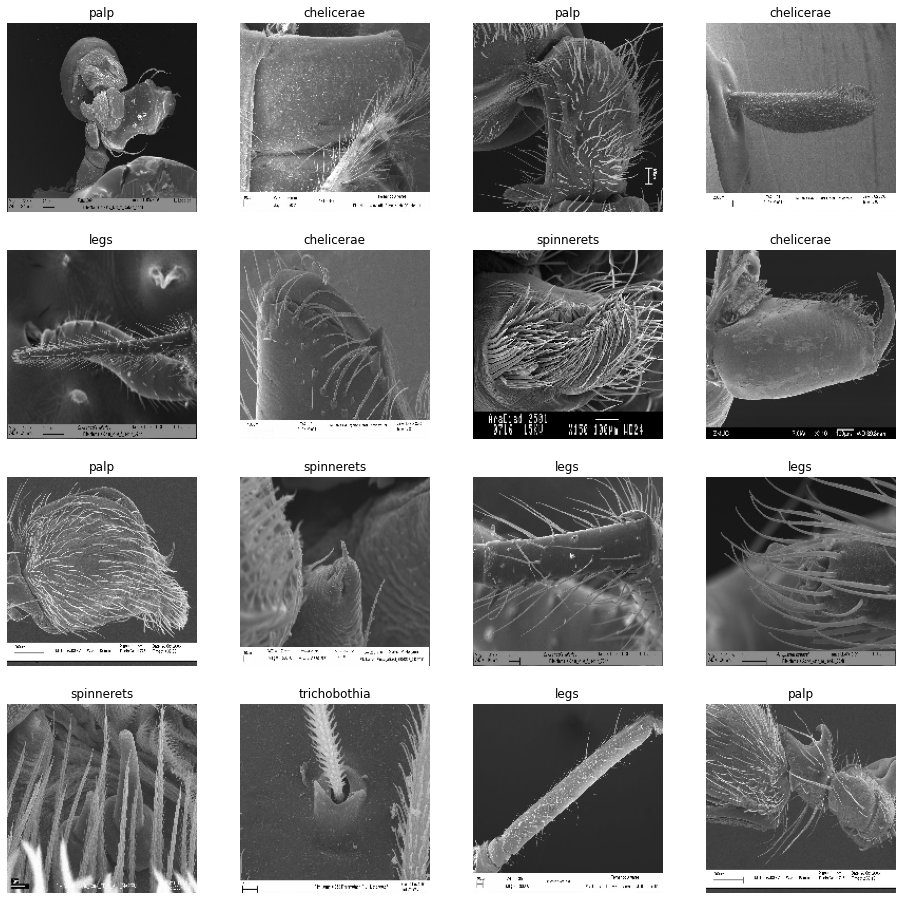

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
for images, labels in train_spider.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_spider:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_spider = train_spider.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_spider = val_spider.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) #using it inside the model 

## Create the model

In [16]:
num_classes = 6

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [19]:
epochs=10
history = model.fit(
  train_spider,
  validation_data=val_spider,
  epochs=epochs
)

Epoch 1/10
147/147 [==============================] - 614s 1s/step - loss: 1.3970 - accuracy: 0.4603 - val_loss: 0.9261 - val_accuracy: 0.6764
Epoch 2/10
147/147 [==============================] - 87s 594ms/step - loss: 0.8259 - accuracy: 0.7181 - val_loss: 0.6878 - val_accuracy: 0.7577
Epoch 3/10
147/147 [==============================] - 91s 619ms/step - loss: 0.4802 - accuracy: 0.8415 - val_loss: 0.6603 - val_accuracy: 0.7748
Epoch 4/10
147/147 [==============================] - 90s 614ms/step - loss: 0.2876 - accuracy: 0.9052 - val_loss: 0.6249 - val_accuracy: 0.7971
Epoch 5/10
147/147 [==============================] - 90s 614ms/step - loss: 0.1168 - accuracy: 0.9688 - val_loss: 0.7741 - val_accuracy: 0.7937
Epoch 6/10
147/147 [==============================] - 90s 615ms/step - loss: 0.0517 - accuracy: 0.9893 - val_loss: 0.8398 - val_accuracy: 0.7971
Epoch 7/10
147/147 [==============================] - 91s 621ms/step - loss: 0.0180 - accuracy: 0.9971 - val_loss: 1.0428 - val_accu

## Visualize training results

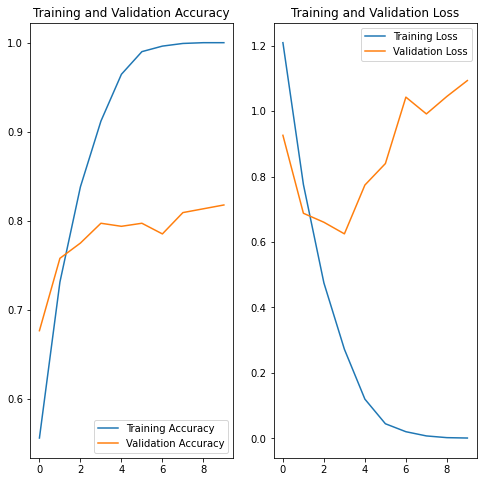

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Model: around 80% accuracy on the validation set.
- Model is probably overfitting (small dataset)

## Increasing the overall performance of the model

### Data augmentation

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

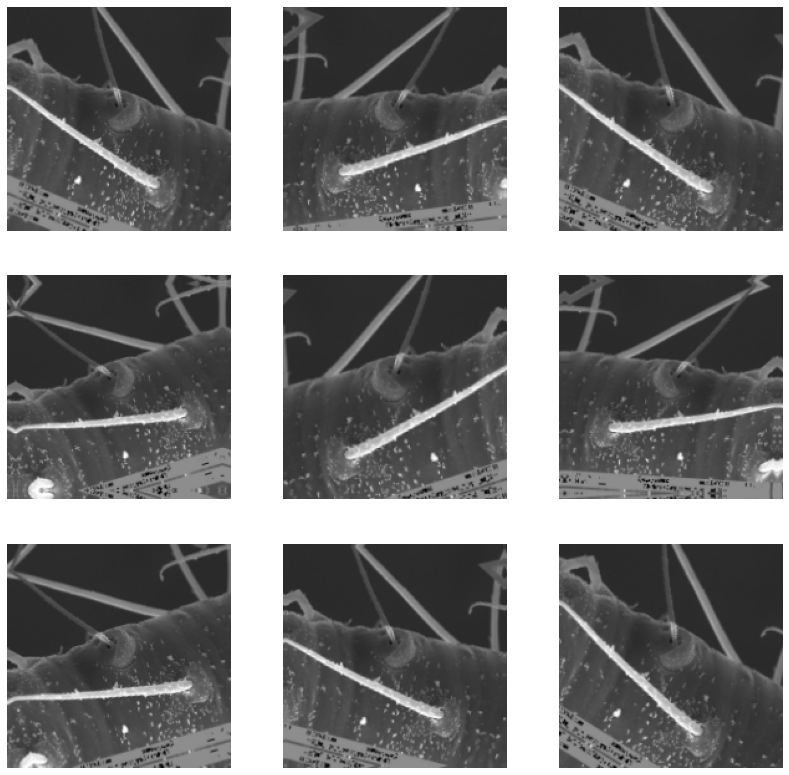

In [26]:
plt.figure(figsize=(14, 14))
for images, _ in train_spider.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [30]:
epochs = 15
history = model.fit(
  train_spider,
  validation_data=val_spider,
  epochs=epochs
)

Epoch 1/15
147/147 [==============================] - 122s 821ms/step - loss: 1.5531 - accuracy: 0.4046 - val_loss: 1.1605 - val_accuracy: 0.5813
Epoch 2/15
147/147 [==============================] - 109s 744ms/step - loss: 1.2473 - accuracy: 0.5413 - val_loss: 1.1435 - val_accuracy: 0.6156
Epoch 3/15
147/147 [==============================] - 118s 802ms/step - loss: 1.0811 - accuracy: 0.5991 - val_loss: 0.9448 - val_accuracy: 0.6764
Epoch 4/15
147/147 [==============================] - 115s 781ms/step - loss: 0.9156 - accuracy: 0.6659 - val_loss: 0.8559 - val_accuracy: 0.6995
Epoch 5/15
147/147 [==============================] - 118s 803ms/step - loss: 0.8585 - accuracy: 0.6946 - val_loss: 0.8950 - val_accuracy: 0.6798
Epoch 6/15
147/147 [==============================] - 112s 761ms/step - loss: 0.7339 - accuracy: 0.7411 - val_loss: 0.7850 - val_accuracy: 0.7303
Epoch 7/15
147/147 [==============================] - 113s 768ms/step - loss: 0.7192 - accuracy: 0.7443 - val_loss: 0.8477 -

## Visualize training results

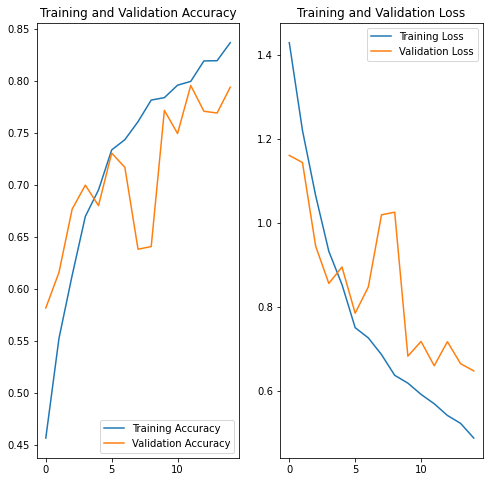

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [32]:
#using images from the internet

image_url = "http://www.spiders.jeremypoolesem.org.uk/EroCambridgei/thumbs/pedipalp.jpg"
image_path = tf.keras.utils.get_file('pedipalp', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to palp with a 99.93 percent confidence.


In [33]:
image_url = "http://www.spiders.jeremypoolesem.org.uk/EroCambridgei/thumbs/headFem.jpg"
image_path = tf.keras.utils.get_file('headFem', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to eyes with a 34.71 percent confidence.


In [34]:
image_url = "http://www.spiders.jeremypoolesem.org.uk/EroCambridgei/thumbs/spinnerets.jpg"
image_path = tf.keras.utils.get_file('spinnerets', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to spinnerets with a 94.54 percent confidence.


In [35]:
image_url = "http://www.spiders.jeremypoolesem.org.uk/EroCambridgei/thumbs/tibia.jpg"
image_path = tf.keras.utils.get_file('tibia', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to legs with a 99.98 percent confidence.


In [36]:
image_url = "https://c8.alamy.com/comp/CRYN36/spider-sem-CRYN36.jpg"
image_path = tf.keras.utils.get_file('spider-sem-CRYN36', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to eyes with a 86.39 percent confidence.


In [37]:
image_url = "https://media.sciencephoto.com/image/c0369998/800wm.jpg"
image_path = tf.keras.utils.get_file('800wm', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to palp with a 61.19 percent confidence.


In [38]:
image_url = "https://media.sciencephoto.com/c0/37/00/25/c0370025-800px-wm.jpg"
image_path = tf.keras.utils.get_file('c0370025-800px-wm', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to legs with a 86.77 percent confidence.


In [39]:
image_url = "https://media.sciencephoto.com/c0/36/99/87/c0369987-800px-wm.jpg"
image_path = tf.keras.utils.get_file('c0369987-800px-wm', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to eyes with a 84.53 percent confidence.


In [40]:
image_url = "https://www.mindenpictures.com/cache/pcache2/00780241.jpg"
image_path = tf.keras.utils.get_file('00780241', origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to eyes with a 76.22 percent confidence.
